# Class code for Comparison Study

SEOYEON CHOI  
2022-11-24

Simulation

| Method                                      |   Category   | JIT Enabled | Multicore | Citation number |
|:--------------------------------------------|:------------:|:-----------:|:---------:|:---------------:|
| LOF (Breunig et al., 2000)                  |  Proximity   |     No      |    Yes    |                 |
| kNN (Ramaswamy et al., 2000)                |  Proximity   |     No      |    Yes    |                 |
| AvgkNN (Angiulli and Pizzuti, 2002)         |  Proximity   |     No      |    Yes    |                 |
| CBLOF (He et al., 2003)                     |  Proximity   |     Yes     |    No     |                 |
| OCSVM (Sch ̈olkopf et al., 2001)             | Linear Model |     No      |    No     |                 |
| LOCI (Papadimitriou et al., 2003)           |  Proximity   |     Yes     |    No     |      1157       |
| PCA (Shyu et al., 2003)                     | Linear Model |     No      |    No     |                 |
| MCD (Hardin and Rocke, 2004)                | Linear Model |     No      |    No     |                 |
| Feature Bagging (Lazarevic and Kumar, 2005) |  Ensembling  |     No      |    Yes    |       705       |
| ABOD (Kriegel et al., 2008)                 |  Proximity   |     Yes     |    No     |       884       |
| Isolation Forest (Liu et al., 2008)         |  Ensembling  |     No      |    Yes    |                 |
| HBOS (Goldstein and Dengel, 2012)           |  Proximity   |     Yes     |    No     |                 |
| SOS (Janssens et al., 2012)                 |  Proximity   |     Yes     |    No     |                 |
| AutoEncoder (Sakurada and Yairi, 2014)      |  Neural Net  |     Yes     |    No     |                 |
| AOM (Aggarwal and Sathe, 2015)              |  Ensembling  |     No      |    No     |                 |
| MOA (Aggarwal and Sathe, 2015)              |  Ensembling  |     No      |    No     |                 |
| SO-GAAL (Liu et al., 2019)                  |  Neural Net  |     No      |    No     |                 |
| MO-GAAL (Liu et al., 2019)                  |  Neural Net  |     No      |    No     |                 |
| XGBOD (Zhao and Hryniewicki, 2018b)         |  Ensembling  |     No      |    Yes    |       93        |
| LSCP (Zhao et al., 2019)                    |  Ensembling  |     No      |    No     |       97        |

------------------------------------------------------------------------

ex - The Stanford bunny data generated using the *pygsp* package is a
common graphics 3D test model and *NN*-graph. It has 2503 data. We use
*filter.Heat* in this package and it calculate data by
$\hat{g}(x) = \exp(\frac{-\tau x}{\lambda_{max}})$ and $\tau$ is 75. We
use Chebyshev polynomial approximation on this filter. We make zero
vector whixh size is 2503, and put -3000 to one value to use a Lanczos
approximation. A Lanczos approximation will resize signals by flattened.

ref: https://pygsp.readthedocs.io/en/v0.5.1/reference/filters.html

------------------------------------------------------------------------

$r = 5 + \cos(\frac{12\pi - (-\pi)}{n})\times i , (i=1,2,\dots , n)$

$r \cos(\frac{\pi - 2\times \pi /n - (-\pi) }{n}\times i)),(i=1,2,\dots ,n)$

$r \sin((\frac{\pi - 2\times \pi /n - (-\pi) }{n}\times i)),(i=1,2,\dots ,n)$

$f = 10 \times (\frac{6 \pi}{n} \times i),(i=1,2, \dots , n)$

------------------------------------------------------------------------

In [939]:
#sample(c(runif(25,-4,-3), runif(25,3,4), rep(0,900))), sd=5, >12
round(fourteen_linear,3)

In [235]:
#sample(c(runif(25,-5,-3), runif(25,3,5), rep(0,950))), sd=5
round(fourteen_linear,3)

In [307]:
#sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950))), sd=5
round(fourteen_linear,3)

In [308]:
# sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950)))
round(fourteen_orbit,3)

In [309]:
round(fourteen_bunny,3)

## Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go
from IPython.display import HTML

import plotly.express as px

from sklearn.covariance import EmpiricalCovariance, MinCovDet

from alibi_detect.od import IForest
# from pyod.models.iforest import IForest

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
import seaborn as sns

from PyNomaly import loop

from sklearn import svm

from pyod.models.lscp import LSCP
from pyod.models.hbos import HBOS

from pyod.models.so_gaal import SO_GAAL
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM

from pyod.models.feature_bagging import FeatureBagging
from pyod.models.sos import SOS

## Class Code

In [3]:
tab_linear = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1"])
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1"])
tab_bunny = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1"])

In [4]:
class Conf_matrx:
    def __init__(self,original,compare,tab):
        self.original = original
        self.compare = compare
        self.tab = tab
    def conf(self,name):
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        print('Accuracy: %.3f' % self.acc)
        print('Precision: %.3f' % self.pre)
        print('Recall: %.3f' % self.rec)
        print('F1 Score: %.3f' % self.f1)
        
        self.tab = self.tab.append(pd.DataFrame({"Accuracy":[self.acc],"Precision":[self.pre],"Recall":[self.rec],"F1":[self.f1]},index = [name]))

In [5]:
class Linear:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=20): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [6]:
class Orbit:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=20): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [7]:
class BUNNY:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

## Linear EbayesThresh

In [134]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

In [1066]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal_1 = sample(c(runif(25,-2,-1.5), runif(25,1.5,2), rep(0,950)))
index_of_trueoutlier_1 = which(signal_1!=0)
index_of_trueoutlier_1
x_1=signal_1+epsilon

In [1067]:
%R -o x_1
%R -o index_of_trueoutlier_1
%R -o signal_1

In [1068]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [1069]:
outlier_true_index_1 = index_of_trueoutlier_1

In [1070]:
outlier_true_value_1 = x_1[index_of_trueoutlier_1]

In [1071]:
outlier_true_one_1 = signal_1.copy()

In [1072]:
outlier_true_one_1 = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one_1))

## Linear

In [1073]:
_x_1 = np.linspace(0,2,1000)
_y1_1 = 5*_x_1
_y_1 = _y1_1 + x_1 # x is epsilon

In [1074]:
_df=pd.DataFrame({'x':_x_1, 'y':_y_1})

In [1075]:
X = np.array(_df)

### GODE

In [1076]:
w=np.zeros((1000,1000))

In [1077]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1078]:
_Linear = Linear(_df)

In [1079]:
_Linear.fit(sd=5)

In [1080]:
outlier_simul_one = (_Linear.df['Residual']**2).tolist()

In [1087]:
outlier_simul_one = list(map(lambda x: -1 if x > 20 else 1,outlier_simul_one))

In [1088]:
_conf = Conf_matrx(outlier_true_one_1,outlier_simul_one,tab_linear)

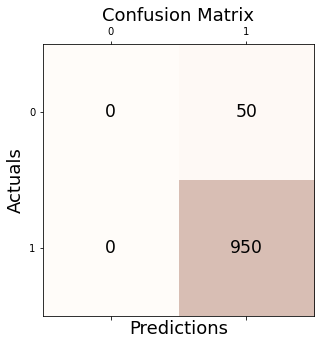

Accuracy: 0.950
Precision: 0.950
Recall: 1.000
F1 Score: 0.974

In [1089]:
_conf.conf("GODE")

In [958]:
one = _conf.tab

### LOF

In [959]:
clf = LocalOutlierFactor(n_neighbors=2)

In [960]:
_conf = Conf_matrx(outlier_true_one_1,clf.fit_predict(X),tab_linear)

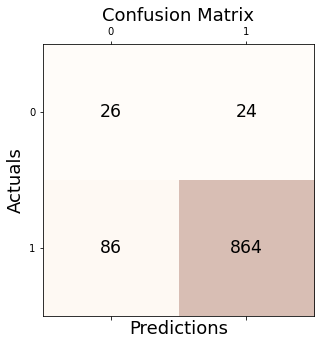

Accuracy: 0.890
Precision: 0.973
Recall: 0.909
F1 Score: 0.940

In [961]:
_conf.conf("LOF (Breunig et al., 2000)")

In [962]:
two = one.append(_conf.tab)

### KNN

In [963]:
from pyod.models.knn import KNN

In [964]:
clf = KNN()
clf.fit(_df[['x', 'y']])
_df['knn_Clf'] = clf.labels_

In [965]:
outlier_KNN_one = list(clf.labels_)

In [966]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [967]:
_conf = Conf_matrx(outlier_true_one_1,outlier_KNN_one,tab_linear)

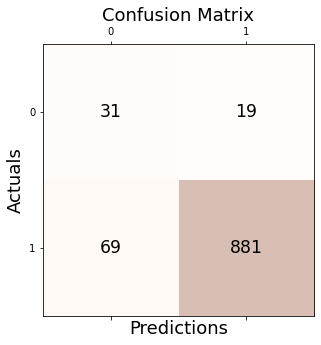

Accuracy: 0.912
Precision: 0.979
Recall: 0.927
F1 Score: 0.952

In [968]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

In [969]:
three = two.append(_conf.tab)

### CBLOF

In [970]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y']])
_df['CBLOF_Clf'] = clf.labels_

In [971]:
outlier_CBLOF_one = list(clf.labels_)

In [972]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [973]:
_conf = Conf_matrx(outlier_true_one_1,outlier_CBLOF_one,tab_linear)

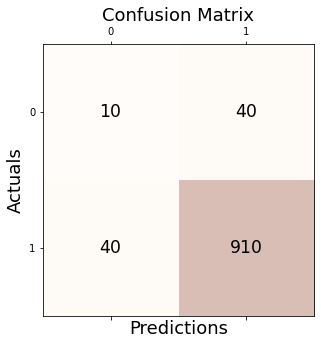

Accuracy: 0.920
Precision: 0.958
Recall: 0.958
F1 Score: 0.958

In [974]:
_conf.conf("CBLOF (He et al., 2003)")

In [975]:
four = three.append(_conf.tab)

### OCSVM

In [976]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [977]:
clf.fit(X)

In [978]:
outlier_OSVM_one = list(clf.predict(X))

In [979]:
_conf = Conf_matrx(outlier_true_one_1,outlier_OSVM_one,tab_linear)

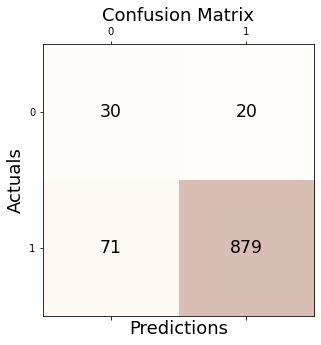

Accuracy: 0.909
Precision: 0.978
Recall: 0.925
F1 Score: 0.951

In [980]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

In [981]:
five = four.append(_conf.tab)

### MCD

In [982]:
clf = MCD()
clf.fit(_df[['x', 'y']])
_df['MCD_clf'] = clf.labels_

In [983]:
outlier_MCD_one = list(clf.labels_)

In [984]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [985]:
_conf = Conf_matrx(outlier_true_one_1,outlier_MCD_one,tab_linear)

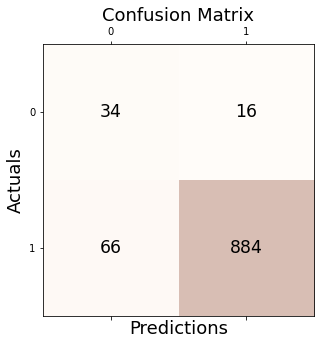

Accuracy: 0.918
Precision: 0.982
Recall: 0.931
F1 Score: 0.956

In [986]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

In [987]:
six = five.append(_conf.tab)

### Feature Bagging

In [988]:
clf = FeatureBagging()
clf.fit(_df[['x', 'y']])
_df['FeatureBagging_clf'] = clf.labels_

In [989]:
outlier_FeatureBagging_one = list(clf.labels_)

In [990]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [991]:
_conf = Conf_matrx(outlier_true_one_1,outlier_FeatureBagging_one,tab_linear)

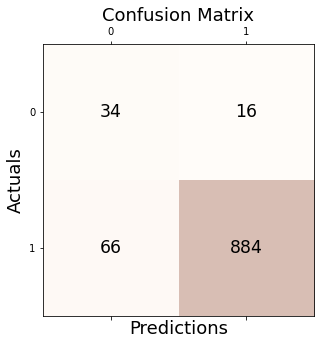

Accuracy: 0.918
Precision: 0.982
Recall: 0.931
F1 Score: 0.956

In [992]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

In [993]:
seven = six.append(_conf.tab)

### ABOD

In [994]:
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = clf.labels_

In [995]:
outlier_ABOD_one = list(clf.labels_)

In [996]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [997]:
_conf = Conf_matrx(outlier_true_one_1,outlier_ABOD_one,tab_linear)

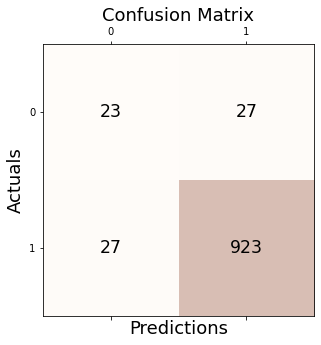

Accuracy: 0.946
Precision: 0.972
Recall: 0.972
F1 Score: 0.972

In [998]:
_conf.conf("ABOD (Kriegel et al., 2008)")

In [999]:
eight = seven.append(_conf.tab)

### IForest

In [1000]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [1001]:
od.fit(_df[['x', 'y']])

In [1002]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

In [1003]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [1004]:
outlier_alibi_one = _df['IF_alibi']

In [1005]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [1006]:
_conf = Conf_matrx(outlier_true_one_1,outlier_alibi_one,tab_linear)

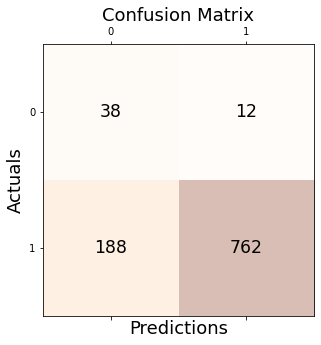

Accuracy: 0.800
Precision: 0.984
Recall: 0.802
F1 Score: 0.884

In [1007]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

In [1008]:
nine = eight.append(_conf.tab)

### HBOS

In [1009]:
clf = HBOS()
clf.fit(_df[['x', 'y']])
_df['HBOS_clf'] = clf.labels_

In [1010]:
outlier_HBOS_one = list(clf.labels_)

In [1011]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [1012]:
_conf = Conf_matrx(outlier_true_one_1,outlier_HBOS_one,tab_linear)

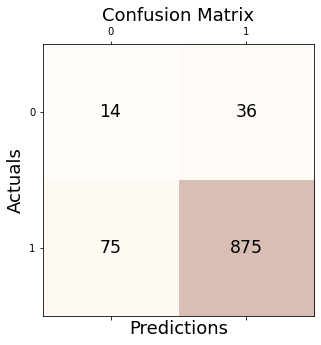

Accuracy: 0.889
Precision: 0.960
Recall: 0.921
F1 Score: 0.940

In [1013]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

In [1014]:
ten = nine.append(_conf.tab)

### SOS

In [1015]:
outlier_SOS_one = list(clf.labels_)

In [1016]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [1017]:
clf = SOS()
clf.fit(_df[['x', 'y']])
_df['SOS_clf'] = clf.labels_

In [1018]:
_conf = Conf_matrx(outlier_true_one_1,outlier_SOS_one,tab_linear)

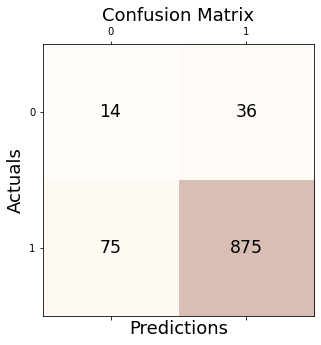

Accuracy: 0.889
Precision: 0.960
Recall: 0.921
F1 Score: 0.940

In [1019]:
_conf.conf("SOS (Janssens et al., 2012)")

In [1020]:
eleven = ten.append(_conf.tab)

### SO_GAAL

In [1021]:
clf = SO_GAAL()
clf.fit(_df[['x', 'y']])
_df['SO_GAAL_clf'] = clf.labels_

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)

In [1022]:
outlier_SO_GAAL_one = list(clf.labels_)

In [1023]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [1024]:
_conf = Conf_matrx(outlier_true_one_1,outlier_SO_GAAL_one,tab_linear)

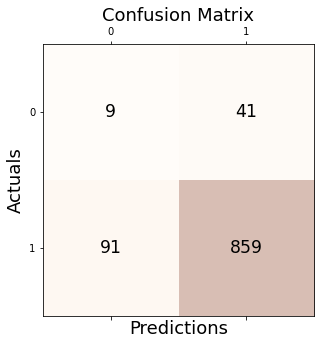

Accuracy: 0.868
Precision: 0.954
Recall: 0.904
F1 Score: 0.929

In [1025]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

In [1026]:
twelve = eleven.append(_conf.tab)

### MO_GAAL

In [1027]:
clf = MO_GAAL()
clf.fit(_df[['x', 'y']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

In [1028]:
outlier_MO_GAAL_one = list(clf.labels_)

In [1029]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [1030]:
_conf = Conf_matrx(outlier_true_one_1,outlier_MO_GAAL_one,tab_linear)

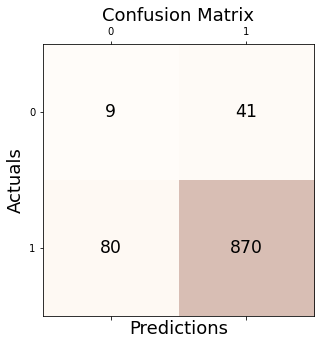

Accuracy: 0.879
Precision: 0.955
Recall: 0.916
F1 Score: 0.935

In [1031]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

In [1032]:
thirteen = twelve.append(_conf.tab)

### LSCP

In [1033]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors)
clf.fit(_df[['x', 'y']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(

In [1034]:
outlier_LSCP_one = list(clf.labels_)

In [1035]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [1036]:
_conf = Conf_matrx(outlier_true_one_1,outlier_LSCP_one,tab_linear)

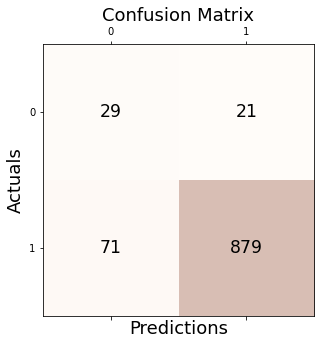

Accuracy: 0.908
Precision: 0.977
Recall: 0.925
F1 Score: 0.950

In [1037]:
_conf.conf("LSCP (Zhao et al., 2019)")

In [1038]:
fourteen_linear = thirteen.append(_conf.tab)

## Linear Result

In [1039]:
round(fourteen_linear,3)

## Orbit EbayesThresh

In [108]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

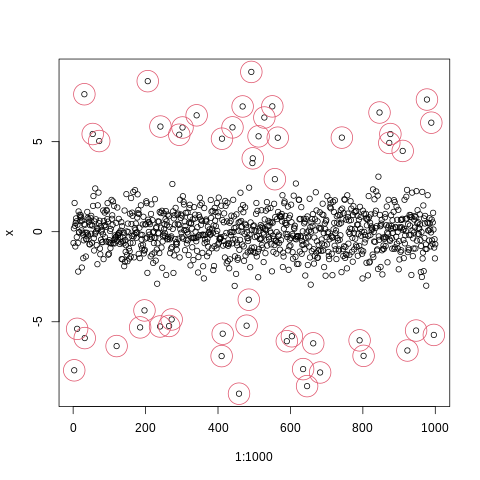

In [109]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier
x=signal+epsilon
plot(1:1000,x)
points(index_of_trueoutlier,x[index_of_trueoutlier],col=2,cex=4)

#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [110]:
%R -o x
%R -o index_of_trueoutlier
%R -o signal

In [111]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [112]:
xhat = np.array(ebayesthresh(FloatVector(x)))

In [113]:
# plt.plot(x)
# plt.plot(xhat)

In [114]:
outlier_true_index = index_of_trueoutlier

In [115]:
outlier_true_value = x[index_of_trueoutlier]

package와 비교를 위해 outlier는 -1, inlier는 1로 표시

In [116]:
outlier_true_one = signal.copy()

In [117]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## Orbit

In [118]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [119]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [120]:
X = np.array(_df)

### GODE

In [121]:
_Orbit = Orbit(_df)

In [122]:
_Orbit.get_distance()

100%|██████████| 1000/1000 [00:02<00:00, 497.54it/s]

In [123]:
_Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=2500) 

In [124]:
_Orbit.fit(sd=15,ref=20)

In [125]:
outlier_simul_one = (_Orbit.df['Residual']**2).tolist()

In [126]:
outlier_simul_one = list(map(lambda x: -1 if x > 20 else 1,outlier_simul_one))

In [127]:
_conf = Conf_matrx(outlier_true_one,outlier_simul_one,tab_orbit)

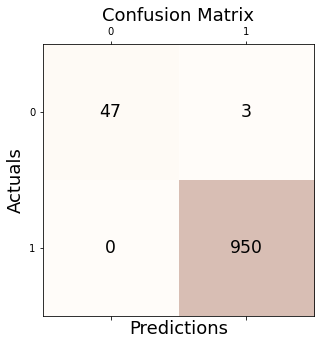

Accuracy: 0.997
Precision: 0.997
Recall: 1.000
F1 Score: 0.998

In [128]:
_conf.conf("GODE")

In [129]:
one = _conf.tab

### LOF

In [130]:
clf = LocalOutlierFactor(n_neighbors=2)

In [131]:
_conf = Conf_matrx(outlier_true_one,clf.fit_predict(X),tab_orbit)

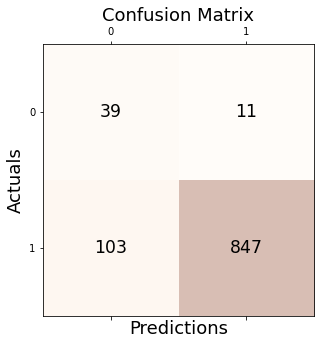

Accuracy: 0.886
Precision: 0.987
Recall: 0.892
F1 Score: 0.937

In [132]:
_conf.conf("LOF (Breunig et al., 2000)")

In [133]:
two = one.append(_conf.tab)

### KNN

In [134]:
clf = KNN()
clf.fit(_df[['x', 'y','f']])
_df['knn_clf'] = clf.labels_

In [135]:
outlier_KNN_one = list(clf.labels_)

In [136]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [137]:
_conf = Conf_matrx(outlier_true_one,outlier_KNN_one,tab_orbit)

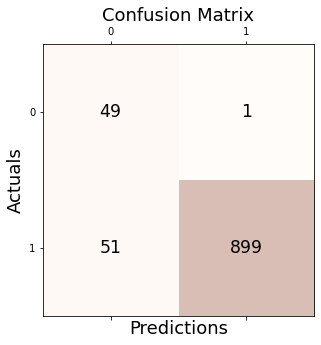

Accuracy: 0.948
Precision: 0.999
Recall: 0.946
F1 Score: 0.972

In [138]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

In [139]:
three = two.append(_conf.tab)

### CBLOF

In [140]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['CBLOF_Clf'] = clf.labels_

In [141]:
outlier_CBLOF_one = list(clf.labels_)

In [142]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [143]:
_conf = Conf_matrx(outlier_true_one,outlier_CBLOF_one,tab_orbit)

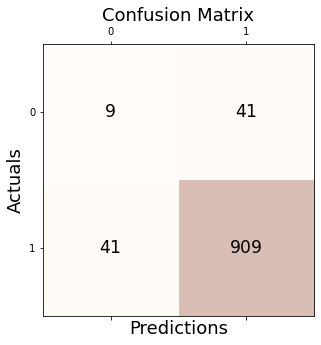

Accuracy: 0.918
Precision: 0.957
Recall: 0.957
F1 Score: 0.957

In [144]:
_conf.conf("CBLOF (He et al., 2003)")

In [145]:
four = three.append(_conf.tab)

### OCSVM

In [146]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [147]:
clf.fit(X)

In [148]:
outlier_OSVM_one = list(clf.predict(X))

In [149]:
_conf = Conf_matrx(outlier_true_one,outlier_OSVM_one,tab_orbit)

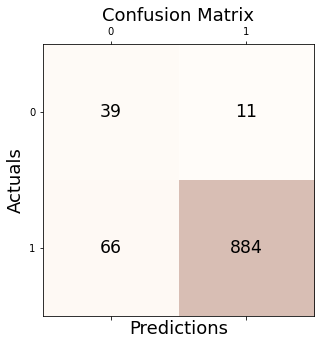

Accuracy: 0.923
Precision: 0.988
Recall: 0.931
F1 Score: 0.958

In [150]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

In [151]:
five = four.append(_conf.tab)

### MCD

In [152]:
clf = MCD()
clf.fit(_df[['x', 'y','f']])
_df['MCD_clf'] = clf.labels_

In [153]:
outlier_MCD_one = list(clf.labels_)

In [154]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [155]:
_conf = Conf_matrx(outlier_true_one,outlier_MCD_one,tab_orbit)

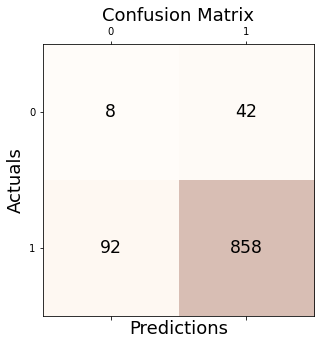

Accuracy: 0.866
Precision: 0.953
Recall: 0.903
F1 Score: 0.928

In [156]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

In [157]:
six = five.append(_conf.tab)

### Feature Bagging

In [158]:
clf = FeatureBagging()
clf.fit(_df[['x', 'y','f']])
_df['FeatureBagging_clf'] = clf.labels_

In [159]:
outlier_FeatureBagging_one = list(clf.labels_)

In [160]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [161]:
_conf = Conf_matrx(outlier_true_one,outlier_FeatureBagging_one,tab_orbit)

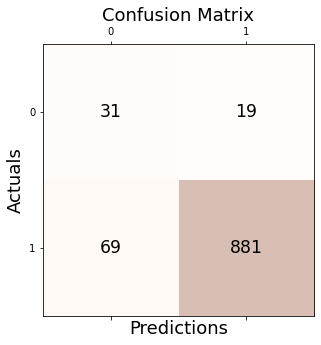

Accuracy: 0.912
Precision: 0.979
Recall: 0.927
F1 Score: 0.952

In [162]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

In [163]:
seven = six.append(_conf.tab)

### ABOD

In [164]:
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['ABOD_Clf'] = clf.labels_

In [165]:
outlier_ABOD_one = list(clf.labels_)

In [166]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [167]:
_conf = Conf_matrx(outlier_true_one,outlier_ABOD_one,tab_orbit)

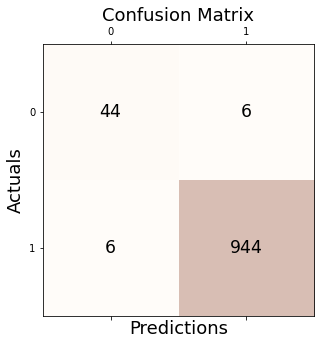

Accuracy: 0.988
Precision: 0.994
Recall: 0.994
F1 Score: 0.994

In [168]:
_conf.conf("ABOD (Kriegel et al., 2008)")

In [169]:
eight = seven.append(_conf.tab)

### IForest

In [170]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [171]:
od.fit(_df[['x', 'y','f']])

In [172]:
preds = od.predict(
    _df[['x', 'y','f']],
    return_instance_score=True
)

In [173]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [174]:
outlier_alibi_one = _df['IF_alibi']

In [175]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [176]:
_conf = Conf_matrx(outlier_true_one,outlier_alibi_one,tab_orbit)

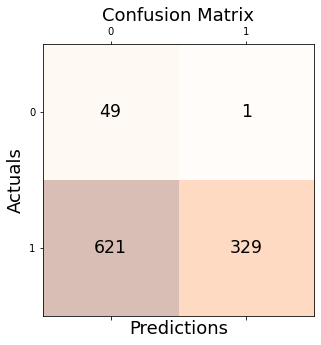

Accuracy: 0.378
Precision: 0.997
Recall: 0.346
F1 Score: 0.514

In [177]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

In [178]:
nine = eight.append(_conf.tab)

### HBOS

In [179]:
clf = HBOS()
clf.fit(_df[['x', 'y','f']])
_df['HBOS_clf'] = clf.labels_

In [180]:
outlier_HBOS_one = list(clf.labels_)

In [181]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [182]:
_conf = Conf_matrx(outlier_true_one,outlier_HBOS_one,tab_orbit)

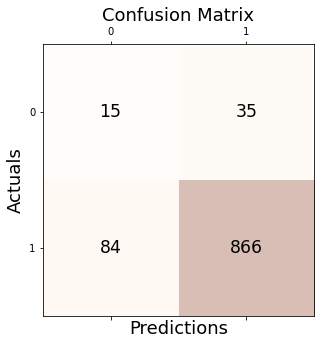

Accuracy: 0.881
Precision: 0.961
Recall: 0.912
F1 Score: 0.936

In [183]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

In [184]:
ten = nine.append(_conf.tab)

### SOS

In [185]:
outlier_SOS_one = list(clf.labels_)

In [186]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [187]:
clf = SOS()
clf.fit(_df[['x', 'y','f']])
_df['SOS_clf'] = clf.labels_

In [188]:
_conf = Conf_matrx(outlier_true_one,outlier_SOS_one,tab_orbit)

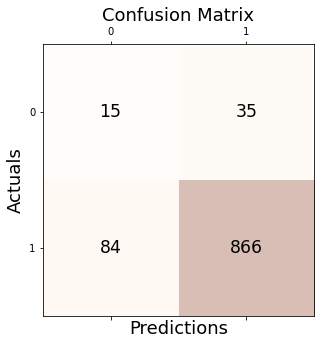

Accuracy: 0.881
Precision: 0.961
Recall: 0.912
F1 Score: 0.936

In [189]:
_conf.conf("SOS (Janssens et al., 2012)")

In [190]:
eleven = ten.append(_conf.tab)

### SO_GAAL

In [191]:
clf = SO_GAAL()
clf.fit(_df[['x', 'y','f']])
_df['SO_GAAL_clf'] = clf.labels_

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)

In [192]:
outlier_SO_GAAL_one = list(clf.labels_)

In [193]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [194]:
_conf = Conf_matrx(outlier_true_one,outlier_SO_GAAL_one,tab_orbit)

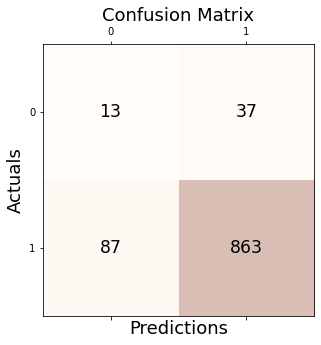

Accuracy: 0.876
Precision: 0.959
Recall: 0.908
F1 Score: 0.933

In [195]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

In [196]:
twelve = eleven.append(_conf.tab)

### MO_GAAL

In [197]:
clf = MO_GAAL()
clf.fit(_df[['x', 'y','f']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

In [198]:
outlier_MO_GAAL_one = list(clf.labels_)

In [199]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [200]:
_conf = Conf_matrx(outlier_true_one,outlier_MO_GAAL_one,tab_orbit)

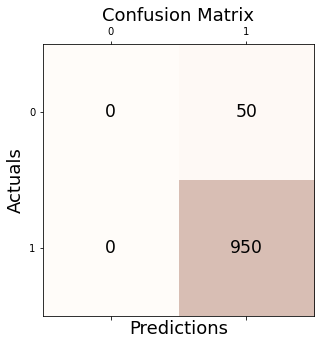

Accuracy: 0.950
Precision: 0.950
Recall: 1.000
F1 Score: 0.974

In [201]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

In [202]:
thirteen = twelve.append(_conf.tab)

### LSCP

In [203]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors)
clf.fit(_df[['x', 'y','f']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(

In [204]:
outlier_LSCP_one = list(clf.labels_)

In [205]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [206]:
_conf = Conf_matrx(outlier_true_one,outlier_LSCP_one,tab_orbit)

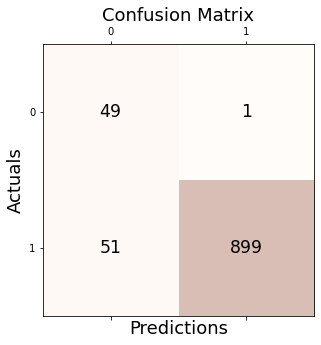

Accuracy: 0.948
Precision: 0.999
Recall: 0.946
F1 Score: 0.972

In [207]:
_conf.conf("LSCP (Zhao et al., 2019)")

In [208]:
fourteen_orbit = thirteen.append(_conf.tab)

## Orbit Result

In [209]:
round(fourteen_orbit,4)

## Bunny

In [210]:
G = graphs.Bunny()
n = G.N

In [211]:
g = filters.Heat(G, tau=75) 

In [212]:
normal = np.random.randn(n)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
index_of_trueoutlier2 = np.where(unif!=0)

In [213]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2022-11-26 07:54:05,353:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.

In [214]:
G.coords.shape

In [215]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [216]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise,'f' : f, 'noise': noise})

In [217]:
outlier_true_one_2 = unif.copy()

In [218]:
outlier_true_one_2 = list(map(lambda x: -1 if x !=0  else 1,outlier_true_one_2))

In [219]:
X = np.array(_df)[:,:4]

### GODE

In [220]:
_BUNNY = BUNNY(_df)

In [221]:
_BUNNY.fit(sd=20,ref=10)

In [222]:
outlier_simul_one = (_BUNNY.df['Residual']**2).tolist()

In [223]:
outlier_simul_one = list(map(lambda x: -1 if x > 10 else 1,outlier_simul_one))

In [224]:
_conf = Conf_matrx(outlier_true_one_2,outlier_simul_one,tab_bunny)

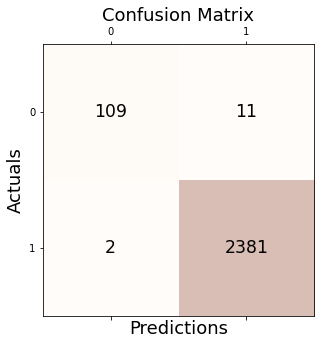

Accuracy: 0.995
Precision: 0.995
Recall: 0.999
F1 Score: 0.997

In [225]:
_conf.conf("GODE")

In [226]:
one = _conf.tab

### LOF

In [227]:
clf = LocalOutlierFactor(n_neighbors=2)

In [228]:
_conf = Conf_matrx(outlier_true_one_2,clf.fit_predict(X),tab_bunny)

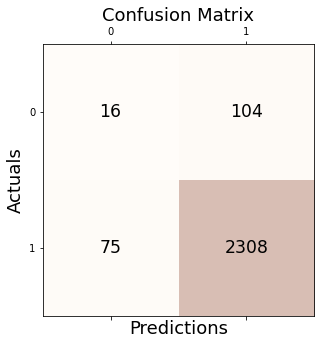

Accuracy: 0.928
Precision: 0.957
Recall: 0.969
F1 Score: 0.963

In [229]:
_conf.conf("LOF (Breunig et al., 2000)")

In [230]:
two = one.append(_conf.tab)

### KNN

In [231]:
clf = KNN()
clf.fit(_df[['x', 'y','fnoise']])
_df['knn_Clf'] = clf.labels_

In [232]:
outlier_KNN_one = list(clf.labels_)

In [233]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [234]:
_conf = Conf_matrx(outlier_true_one_2,outlier_KNN_one,tab_bunny)

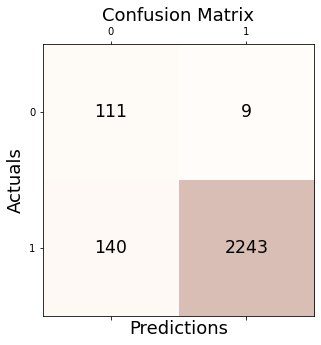

Accuracy: 0.940
Precision: 0.996
Recall: 0.941
F1 Score: 0.968

In [235]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

In [236]:
three = two.append(_conf.tab)

### CBLOF

In [237]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])
_df['CBLOF_Clf'] = clf.labels_

In [238]:
outlier_CBLOF_one = list(clf.labels_)

In [239]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [240]:
_conf = Conf_matrx(outlier_true_one_2,outlier_CBLOF_one,tab_bunny)

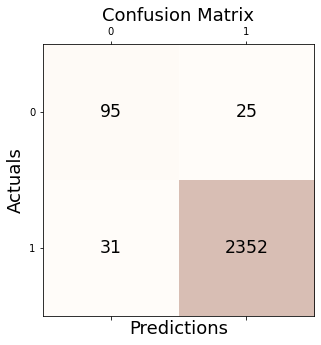

Accuracy: 0.978
Precision: 0.989
Recall: 0.987
F1 Score: 0.988

In [241]:
_conf.conf("CBLOF (He et al., 2003)")

In [242]:
four = three.append(_conf.tab)

### OCSVM

In [243]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [244]:
clf.fit(X)

In [245]:
outlier_OSVM_one = list(clf.predict(X))

In [246]:
_conf = Conf_matrx(outlier_true_one_2,outlier_OSVM_one,tab_bunny)

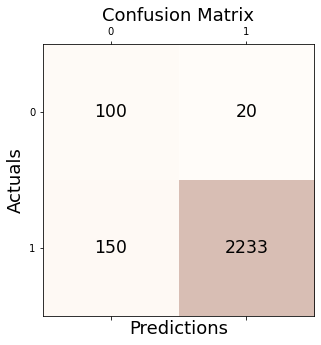

Accuracy: 0.932
Precision: 0.991
Recall: 0.937
F1 Score: 0.963

In [247]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

In [248]:
five = four.append(_conf.tab)

### MCD

In [249]:
clf = MCD()
clf.fit(_df[['x', 'y','fnoise']])
_df['MCD_clf'] = clf.labels_

In [250]:
outlier_MCD_one = list(clf.labels_)

In [251]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [252]:
_conf = Conf_matrx(outlier_true_one_2,outlier_MCD_one,tab_bunny)

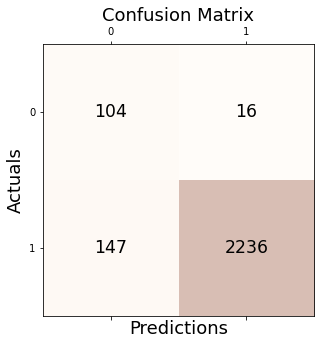

Accuracy: 0.935
Precision: 0.993
Recall: 0.938
F1 Score: 0.965

In [253]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

In [254]:
six = five.append(_conf.tab)

### Feature Bagging

In [255]:
clf = FeatureBagging()
clf.fit(_df[['x', 'y','fnoise']])
_df['FeatureBagging_clf'] = clf.labels_

In [256]:
outlier_FeatureBagging_one = list(clf.labels_)

In [257]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [258]:
_conf = Conf_matrx(outlier_true_one_2,outlier_FeatureBagging_one,tab_bunny)

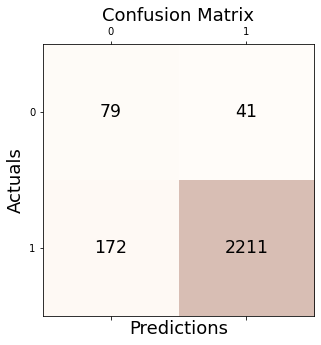

Accuracy: 0.915
Precision: 0.982
Recall: 0.928
F1 Score: 0.954

In [259]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

In [260]:
seven = six.append(_conf.tab)

### ABOD

In [261]:
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['ABOD_Clf'] = clf.labels_

In [262]:
outlier_ABOD_one = list(clf.labels_)

In [263]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [264]:
_conf = Conf_matrx(outlier_true_one_2,outlier_ABOD_one,tab_bunny)

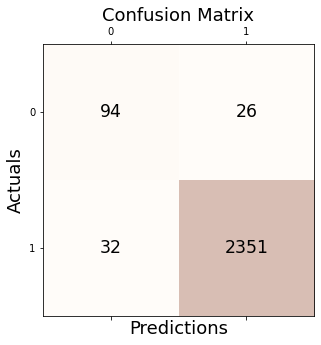

Accuracy: 0.977
Precision: 0.989
Recall: 0.987
F1 Score: 0.988

In [265]:
_conf.conf("ABOD (Kriegel et al., 2008)")

In [266]:
eight = seven.append(_conf.tab)

### IForest

In [267]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [268]:
od.fit(_df[['x', 'y','fnoise']])

In [269]:
preds = od.predict(
    _df[['x', 'y','fnoise']],
    return_instance_score=True
)

In [270]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [271]:
outlier_alibi_one = _df['IF_alibi']

In [272]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [273]:
_conf = Conf_matrx(outlier_true_one_2,outlier_alibi_one,tab_bunny)

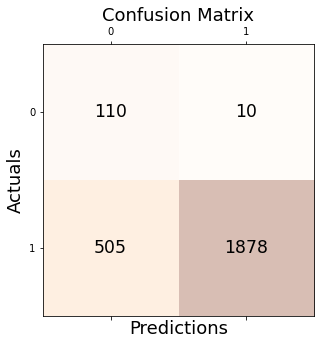

Accuracy: 0.794
Precision: 0.995
Recall: 0.788
F1 Score: 0.879

In [274]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

In [275]:
nine = eight.append(_conf.tab)

### HBOS

In [276]:
clf = HBOS()
clf.fit(_df[['x', 'y','fnoise']])
_df['HBOS_clf'] = clf.labels_

In [277]:
outlier_HBOS_one = list(clf.labels_)

In [278]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [279]:
_conf = Conf_matrx(outlier_true_one_2,outlier_HBOS_one,tab_bunny)

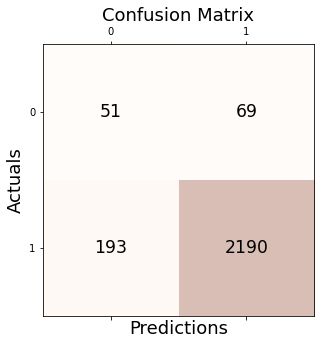

Accuracy: 0.895
Precision: 0.969
Recall: 0.919
F1 Score: 0.944

In [280]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

In [281]:
ten = nine.append(_conf.tab)

### SOS

In [282]:
outlier_SOS_one = list(clf.labels_)

In [283]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [284]:
clf = SOS()
clf.fit(_df[['x', 'y','fnoise']])
_df['SOS_clf'] = clf.labels_

In [285]:
_conf = Conf_matrx(outlier_true_one_2,outlier_SOS_one,tab_bunny)

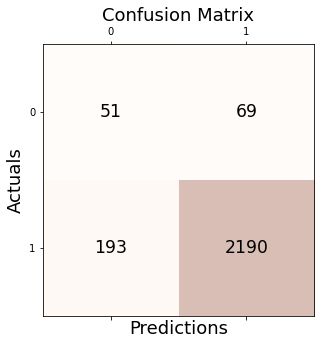

Accuracy: 0.895
Precision: 0.969
Recall: 0.919
F1 Score: 0.944

In [286]:
_conf.conf("SOS (Janssens et al., 2012)")

In [287]:
eleven = ten.append(_conf.tab)

### SO_GAAL

In [288]:
clf = SO_GAAL()
clf.fit(_df[['x', 'y','fnoise']])
_df['SO_GAAL_clf'] = clf.labels_

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:

Testing for epoch 4 index 4:

Testing for epoch 4 index 5:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:

Testing for epoch 5 index 4:

Testing for epoch 5 index 5:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:

Testing for epoch 6 index 4:

Testing for epoch 6 index 5:
Epoch 7 of 60

T

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)

In [289]:
outlier_SO_GAAL_one = list(clf.labels_)

In [290]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [291]:
_conf = Conf_matrx(outlier_true_one_2,outlier_SO_GAAL_one,tab_bunny)

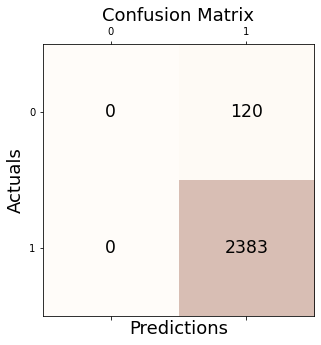

Accuracy: 0.952
Precision: 0.952
Recall: 1.000
F1 Score: 0.975

In [292]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

In [293]:
twelve = eleven.append(_conf.tab)

### MO_GAAL

In [294]:
clf = MO_GAAL()
clf.fit(_df[['x', 'y','fnoise']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:

Testing for epoch 4 index 4:

Testing for epoch 4 index 5:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:

Testing for epoch 5 index 4:

Testing for epoch 5 index 5:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:

Testing for epoch 6 index 4:

Testing for epoch 6 index 5:
Epoch 7 of 60

T

In [295]:
outlier_MO_GAAL_one = list(clf.labels_)

In [296]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [297]:
_conf = Conf_matrx(outlier_true_one_2,outlier_MO_GAAL_one,tab_bunny)

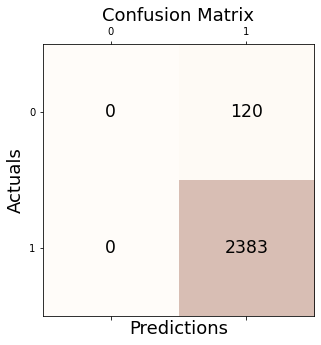

Accuracy: 0.952
Precision: 0.952
Recall: 1.000
F1 Score: 0.975

In [298]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

In [299]:
thirteen = twelve.append(_conf.tab)

### LSCP

In [300]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors)
clf.fit(_df[['x', 'y','fnoise']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(

In [301]:
outlier_LSCP_one = list(clf.labels_)

In [302]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [303]:
_conf = Conf_matrx(outlier_true_one_2,outlier_LSCP_one,tab_bunny)

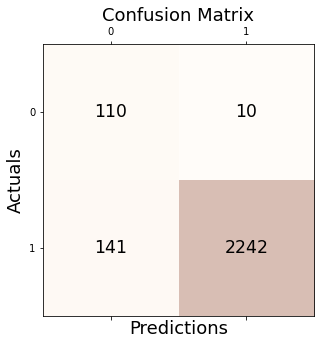

Accuracy: 0.940
Precision: 0.996
Recall: 0.941
F1 Score: 0.967

In [304]:
_conf.conf("LSCP (Zhao et al., 2019)")

In [305]:
fourteen_bunny = thirteen.append(_conf.tab)

## Bunny Result

In [306]:
round(fourteen_bunny,4)